In [1]:
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x) 

## What is the most optimal skill to learn for data analysts based on demand and pay?

### Methodology
- Group skills to determine the median salary and likelihood of being in a job posting
- Visualize median salary vs percent skill demand


In [4]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()
df_DA_US.head(_)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
36,Data Analyst,Data Analyst,"Des Moines, IA",via Trabajo.org,Full-time,False,"Illinois, United States",2023-11-06 13:01:22,False,True,United States,None,NaN,NaN,Assuredpartners,None,None
68,Data Analyst,Sr. Research Data Analyst,"Baltimore, MD",via ZipRecruiter,Full-time,False,"New York, United States",2023-03-24 13:01:00,False,False,United States,None,NaN,NaN,Johns Hopkins Medicine,"[r, zoom]","{'programming': ['r'], 'sync': ['zoom']}"
73,Data Analyst,Entry level / Systems Data Analyst (Remote),Anywhere,via LinkedIn,Contractor,True,"Illinois, United States",2023-06-16 13:18:22,True,True,United States,None,NaN,NaN,Soft Magic,"[word, excel, powerpoint, outlook]","{'analyst_tools': ['word', 'excel', 'powerpoin..."
79,Data Analyst,Data Analyst/Report Writer,"Austin, TX",via Jobs Trabajo.org,Full-time,False,"Texas, United States",2023-08-07 13:18:27,True,False,United States,None,NaN,NaN,Nesco Resource,"[sas, sas, word, excel]","{'analyst_tools': ['sas', 'word', 'excel'], 'p..."
93,Data Analyst,IT Finance / TBM Data Analyst - Remote | WFH,Anywhere,via LinkedIn,Full-time,True,"New York, United States",2023-06-10 13:00:05,False,False,United States,None,NaN,NaN,Get It Recruit - Information Technology,"[oracle, azure, power bi, excel, word, powerpo...","{'analyst_tools': ['power bi', 'excel', 'word'..."


In [6]:
df_DA_US = df_DA_US.dropna(subset='salary_year_avg')

In [8]:
df_DA_exploded = df_DA_US.explode('job_skills')

In [34]:
df_DA_skills = df_DA_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_DA_skills = df_DA_skills.rename(columns={'count':'skill_count', 'median':'median_salary'}) # renaming columns
df_DA_skills

,skill_count,median_salary
job_skills,,
sql,2508,91000.0
excel,1808,84392.0
python,1431,97500.0
tableau,1364,92875.0
sas,926,90000.0
...,...,...
couchbase,1,160515.0
chainer,1,100000.0
chef,1,85000.0


To calculate the percentage of skills appearing on job postings, we need to create a new column to insert percentages and find out the total number of data analyst jobs in the US.

In [35]:
job_total = len(df_DA_US) # there are 4,350 data analyst job postings in the US which possess a value for 'salary_year_avg'
job_total

4350

In [36]:
df_DA_skills['skills_percent'] = (df_DA_skills['skill_count'] / job_total) * 100
df_DA_skills

,skill_count,median_salary,skills_percent
job_skills,,,
sql,2508,91000.0,57.655172
excel,1808,84392.0,41.563218
python,1431,97500.0,32.896552
tableau,1364,92875.0,31.356322
sas,926,90000.0,21.287356
...,...,...,...
couchbase,1,160515.0,0.022989
chainer,1,100000.0,0.022989
chef,1,85000.0,0.022989


In [39]:
skill_limit = 5
df_DA_skills = df_DA_skills[df_DA_skills['skills_percent'] > skill_limit]
df_DA_skills

,skill_count,median_salary,skills_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


### Plotting the data

In [41]:
from adjustText import adjust_text

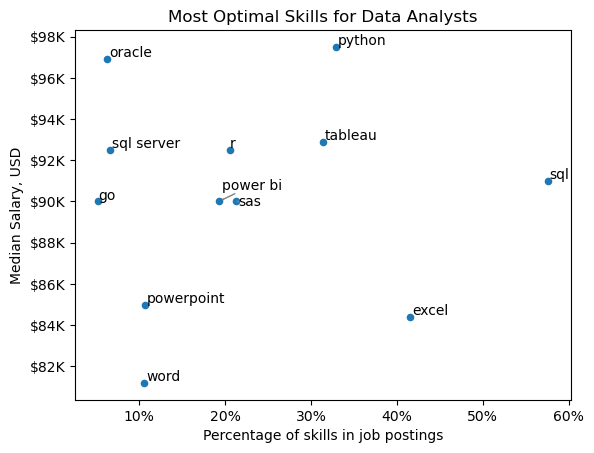

In [49]:
df_DA_skills.plot(kind='scatter', x='skills_percent', y='median_salary')  

text_list = []
for i, txt in enumerate(df_DA_skills.index):
    text_list.append(plt.text(df_DA_skills['skills_percent'].loc[txt], df_DA_skills['median_salary'].loc[txt], txt))

adjust_text(text_list, arrowprops=dict(arrowstyle='->', color='gray', lw=1)) 


ax = plt.gca() 
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x)}%'))


plt.xlabel('Percentage of skills in job postings')
plt.ylabel('Median Salary, USD')
plt.title('Most Optimal Skills for Data Analysts')
plt.show()

### Labelling each skill by its skilltype

In [50]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['ms access',
  'sharepoint',
  'alteryx',
  'powerpoint',
  'excel',
  'splunk',
  'sheets',
  'visio',
  'spss',
  'qlik',
  'tableau',
  'looker',
  'esquisse',
  'powerbi',
  'outlook',
  'nuix',
  'sas',
  'dax',
  'datarobot',
  'spreadsheet',
  'word',
  'cognos',
  'ssrs',
  'sap',
  'ssis',
  'msaccess',
  'power bi',
  'microstrategy'],
 'programming': ['crystal',
  'matlab',
  'javascript',
  't-sql',
  'kotlin',
  'groovy',
  'haskell',
  'ocaml',
  'scala',
  'fortran',
  'c',
  'assembly',
  'visualbasic',
  'objective-c',
  'visual basic',
  'php',
  'no-sql',
  'ruby',
  'c#',
  'delphi',
  'mongodb',
  'css',
  'vba',
  'go',
  'f#',
  'java',
  'c++',
  'perl',
  'lisp',
  'vb.net',
  'nosql',
  'sas',
  'dart',
  'pascal',
  'sql',
  'html',
  'clojure',
  'elixir',
  'erlang',
  'shell',
  'sass',
  'swift',
  'solidity',
  'apl',
  'cobol',
  'lua',
  'rust',
  'typescript',
  'r',
  'bash',
  'mongo',
  'powershell',
  'golang',
  'python',
  'ju

In [52]:
# convert dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])
df_technology

,technology,skills
0,analyst_tools,"[ms access, sharepoint, alteryx, powerpoint, e..."
1,programming,"[crystal, matlab, javascript, t-sql, kotlin, g..."
2,cloud,"[firebase, openstack, redshift, aurora, heroku..."
3,libraries,"[scikit-learn, react, seaborn, graphql, capaci..."
4,other,"[svn, npm, puppet, chef, unreal, homebrew, yar..."
5,databases,"[db2, sqlite, mysql, couchbase, couchdb, fireb..."
6,os,"[macos, wsl, suse, debian, ubuntu, unix, arch,..."
7,async,"[workfront, microsoft lists, confluence, wrike..."
8,webframeworks,"[svelte, asp.net core, vue, angular, nuxt.js, ..."
9,sync,"[webex, slack, ringcentral, unify, wire, googl..."


In [53]:
df_technology = df_technology.explode('skills')
df_technology 
# we can now merge this with the original df_DA_skills df

,technology,skills
0,analyst_tools,ms access
0,analyst_tools,sharepoint
0,analyst_tools,alteryx
0,analyst_tools,powerpoint
0,analyst_tools,excel
...,...,...
9,sync,microsoft teams
9,sync,zoom
9,sync,rocketchat
9,sync,twilio


In [55]:
df_plot = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')
df_plot
# a single merged df which now contains the technology column

,skill_count,median_salary,skills_percent,technology,skills
0,2508,91000.00,57.655172,programming,sql
1,1808,84392.00,41.563218,analyst_tools,excel
2,1431,97500.00,32.896552,programming,python
3,1364,92875.00,31.356322,analyst_tools,tableau
4,926,90000.00,21.287356,analyst_tools,sas
5,926,90000.00,21.287356,programming,sas
6,893,92500.00,20.528736,programming,r
7,838,90000.00,19.264368,analyst_tools,power bi
8,462,85000.00,10.620690,analyst_tools,powerpoint
9,461,81194.75,10.597701,analyst_tools,word


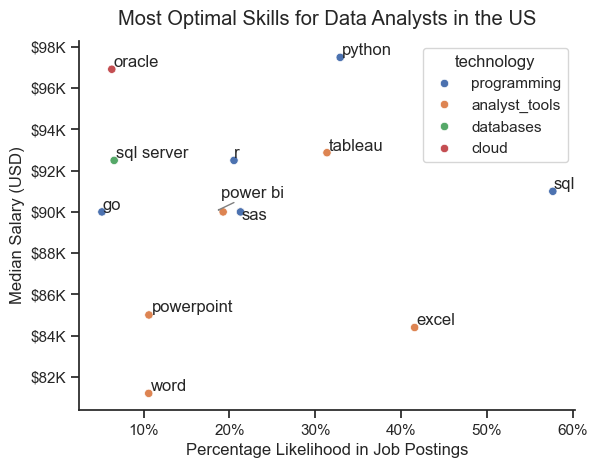

In [107]:
sns.scatterplot(data=df_plot, x='skills_percent', y='median_salary', hue='technology')  
sns.despine()

text_list = []
for i, txt in enumerate(df_DA_skills.index):
    x = df_DA_skills['skills_percent'].iloc[i]
    y = df_DA_skills['median_salary'].iloc[i]

    # Check if the label is "power bi" and set a custom offset
    if txt == 'power bi':
        text = plt.text(x - 1, y + 3, txt)  # Add offset for "power bi"
    else:
        text = plt.text(x, y, txt)  # Default position for others
    # Append each label to the text list
    text_list.append(text)

adjust_text(text_list, arrowprops=dict(arrowstyle='->', color='gray', lw=1)) 


ax = plt.gca() 
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x)}%'))


plt.xlabel('Percentage Likelihood in Job Postings')
plt.ylabel('Median Salary (USD)')
plt.title('Most Optimal Skills for Data Analysts in the US', y=1.02, fontsize=14.5)
plt.show()
